<h1> Create Keras Wide-and-Deep model </h1>

This notebook illustrates:
<ol>
<li> Creating a model using Keras. This requires TensorFlow 2.1
</ol>

In [ ]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1

In [ ]:
# change these to try this notebook out
BUCKET = 'qwiklabs-gcp-02-662ade991eea'
PROJECT = 'qwiklabs-gcp-02-662ade991eea'
REGION = 'us-central1'

In [ ]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [ ]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

In [ ]:
%%bash
ls *.csv

eval.csv
train.csv


## Create Keras model
<p>
First, write an input_fn to read the data.

In [ ]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.3.1


In [ ]:
# Determine CSV, label, and key columns
CSV_COLUMNS = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN = 'key'

# Set default values for each CSV column. Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

In [ ]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

Next, define the feature columns. mother_age and gestation_weeks should be numeric.
The others (is_male, plurality) should be categorical.

In [ ]:
## Build a Keras wide-and-deep model using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Helper function to handle categorical columns
def categorical_fc(name, values):
    orig = tf.feature_column.categorical_column_with_vocabulary_list(name, values)
    wrapped = tf.feature_column.indicator_column(orig)
    return orig, wrapped

def build_wd_model(dnn_hidden_units = [64, 32], nembeds = 3):
    # input layer
    deep_inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in ['mother_age', 'gestation_weeks']
    }
    wide_inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
           for colname in ['is_male', 'plurality']        
    }
    inputs = {**wide_inputs, **deep_inputs}
    
    # feature columns from inputs
    deep_fc = {
        colname : tf.feature_column.numeric_column(colname)
           for colname in ['mother_age', 'gestation_weeks']
    }
    wide_fc = {}
    is_male, wide_fc['is_male'] = categorical_fc('is_male', ['True', 'False', 'Unknown'])
    plurality, wide_fc['plurality'] = categorical_fc('plurality',
                      ['Single(1)', 'Twins(2)', 'Triplets(3)',
                       'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)'])
    
    # bucketize the float fields. This makes them wide
    age_buckets = tf.feature_column.bucketized_column(deep_fc['mother_age'],
                                                     boundaries=np.arange(15,45,1).tolist())
    wide_fc['age_buckets'] = tf.feature_column.indicator_column(age_buckets)
    gestation_buckets = tf.feature_column.bucketized_column(deep_fc['gestation_weeks'],
                                                     boundaries=np.arange(17,47,1).tolist())
    wide_fc['gestation_buckets'] = tf.feature_column.indicator_column(gestation_buckets)
    
    # cross all the wide columns. We have to do the crossing before we one-hot encode
    crossed = tf.feature_column.crossed_column(
        [is_male, plurality, age_buckets, gestation_buckets], hash_bucket_size=20000)
    deep_fc['crossed_embeds'] = tf.feature_column.embedding_column(crossed, nembeds)

    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    wide_inputs = tf.keras.layers.DenseFeatures(wide_fc.values(), name='wide_inputs')(inputs)
    deep_inputs = tf.keras.layers.DenseFeatures(deep_fc.values(), name='deep_inputs')(inputs)
        
    # hidden layers for the deep side
    layers = [int(x) for x in dnn_hidden_units]
    deep = deep_inputs
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    deep_out = deep
    
    # linear model for the wide side
    wide_out = tf.keras.layers.Dense(10, activation='relu', name='linear')(wide_inputs)
   
    # concatenate the two sides
    both = tf.keras.layers.concatenate([deep_out, wide_out], name='both')

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='weight')(both)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])
    return model

print("Here is our Wide-and-Deep architecture so far:\n")
model = build_wd_model()
print(model.summary())

Here is our Wide-and-Deep architecture so far:

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None,)]            0                                            
_______________________________________

We can visualize the DNN using the Keras plot_model utility.

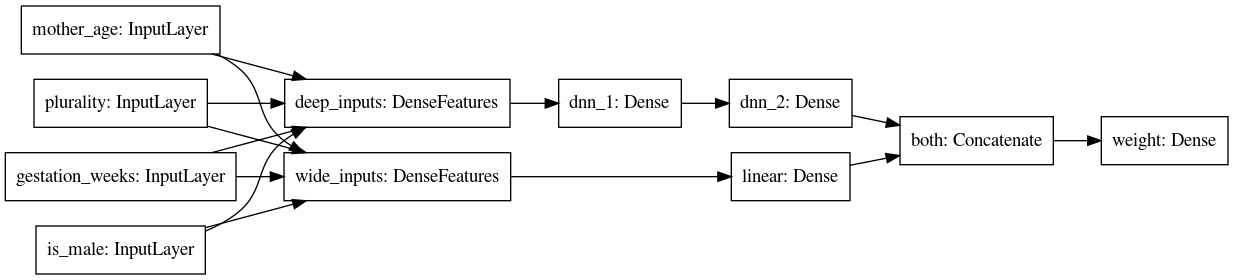

In [ ]:
tf.keras.utils.plot_model(model, 'wd_model.png', show_shapes=False, rankdir='LR')

## Train and evaluate

In [ ]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset('train*', TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset('eval*', 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/5
312/312 [==============================] - 4s 12ms/step - loss: 2.1760 - rmse: 1.2786 - mse: 2.1760 - val_loss: 1.3051 - val_rmse: 1.1420 - val_mse: 1.3051
Epoch 2/5
312/312 [==============================] - 2s 7ms/step - loss: 1.2339 - rmse: 1.0954 - mse: 1.2339 - val_loss: 1.2094 - val_rmse: 1.0991 - val_mse: 1.2094
Epoch 3/5
312/312 [==============================] - 2s 8ms/step - loss: 1.1667 - rmse: 1.0673 - mse: 1.1667 - val_loss: 1.1654 - val_rmse: 1.0793 - val_mse: 1.1654
Epoch 4/5
312/312 [==============================] - 3s 11ms/step - loss: 1.1299 - rmse: 1.0500 - mse: 1.1299 - val_loss: 1.1300 - val_rmse: 1.0629 - val_mse: 1.1300
Epoch 5/5
312/312 [==============================] - 2s 8ms/step - loss: 1.1252 - rmse: 1.0494 - mse: 1.1252 - val_loss: 1.1132 - val_rmse: 1.0549 - val_mse: 1.1132


## Visualize loss curve

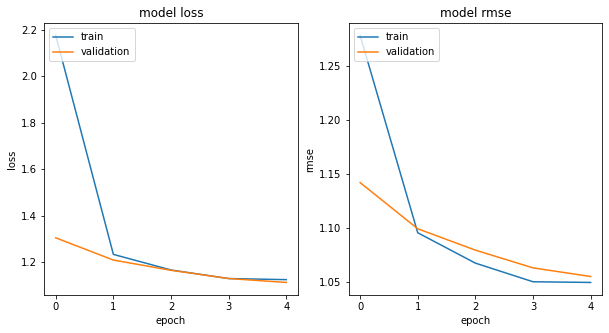

In [ ]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Save the model

In [ ]:
import shutil, os, datetime
OUTPUT_DIR = 'babyweight_trained'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))
tf.saved_model.save(model, EXPORT_PATH) # with default serving function
print("Exported trained model to {}".format(EXPORT_PATH))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: babyweight_trained/20201216093913/assets
Exported trained model to babyweight_trained/20201216093913


In [ ]:
!ls $EXPORT_PATH

assets	saved_model.pb	variables


Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License